In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import signal

import os
import librosa as lb

import IPython.display as ipd

from scipy.ndimage import gaussian_filter1d

In [2]:
data_path = './data/labeled_sample/00001073/'

df = pd.read_csv('./data/evaluation.csv')
df.sort_values(by=['audio_file_id'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

patient_id stage_type        audio_file_id  breathing_counts
0        1073    NonREM2  00001073_01_003_002                 1
1        1073    NonREM2  00001073_01_003_003                 5
2        1073    NonREM2  00001073_01_003_004                 3
3        1073    NonREM2  00001073_01_003_005                 2
4        1073    NonREM2  00001073_01_003_006                 2
5        1073    NonREM2  00001073_01_003_007                 4
6        1073    NonREM1  00001073_01_004_001                 6
7        1073    NonREM3  00001073_01_006_010                 3
8        1073        REM  00001073_02_008_008                 4
9        1073        REM  00001073_02_008_009                 4

In [3]:
labels = df['breathing_counts'].values

In [4]:
audio_files = []

for dir_name, _, file_name in os.walk(data_path):
    for file in file_name:
        full_path = os.path.join(dir_name, file)
        audio_files.append(full_path)

audio_files

['./data/labeled_sample/00001073/00001073_01_003_002.wav',
 './data/labeled_sample/00001073/00001073_01_003_003.wav',
 './data/labeled_sample/00001073/00001073_01_003_004.wav',
 './data/labeled_sample/00001073/00001073_01_003_005.wav',
 './data/labeled_sample/00001073/00001073_01_003_006.wav',
 './data/labeled_sample/00001073/00001073_01_003_007.wav',
 './data/labeled_sample/00001073/00001073_01_004_001.wav',
 './data/labeled_sample/00001073/00001073_01_006_010.wav',
 './data/labeled_sample/00001073/00001073_02_008_008.wav',
 './data/labeled_sample/00001073/00001073_02_008_009.wav']

In [5]:
sample_rate = 44100

def load_audio(audio_file):
    output_audio = []
    for file in audio_file:
        audio, _ = lb.load(file, sr=sample_rate)
        output_audio.append(audio)
    return output_audio

audio = load_audio(audio_files)
len(audio)

10

In [6]:
# upper_cutoff = 15000
# cutoff_freq = [1000, upper_cutoff]

high_pass = signal.firwin(101, 1000, pass_zero= 'highpass', fs=sample_rate)

def apply_high_pass_filter(sig_array):
    return signal.lfilter(high_pass, [1.0], sig_array)

# y_noise=noise,

# def apply_noise_reduction(sig_array):
#     return nr.reduce_noise(y=sig_array, sr=sample_rate, y_noise=noise, stationary=True)

def apply_log_compression(sig_array, gamma):
    sign = np.sign(sig_array)
    abs_signal = 1 + np.abs(sig_array) * gamma
    logged = np.log(abs_signal)
    scaled = logged * (1 / np.log(1.0 + gamma))
    return sign * scaled

def nomalize_volume(sig_array):
    minAmp, maxAmp = np.amin(sig_array), np.amax(sig_array)
    max_energy = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / max_energy
    sig_array *= scale
    return sig_array

noise_removed = []

for sig in audio:
    sig = apply_high_pass_filter(sig)
    # sig = apply_noise_reduction(sig)
    sig = apply_log_compression(sig, 0.5)
    sig = nomalize_volume(sig)
    noise_removed.append(sig)

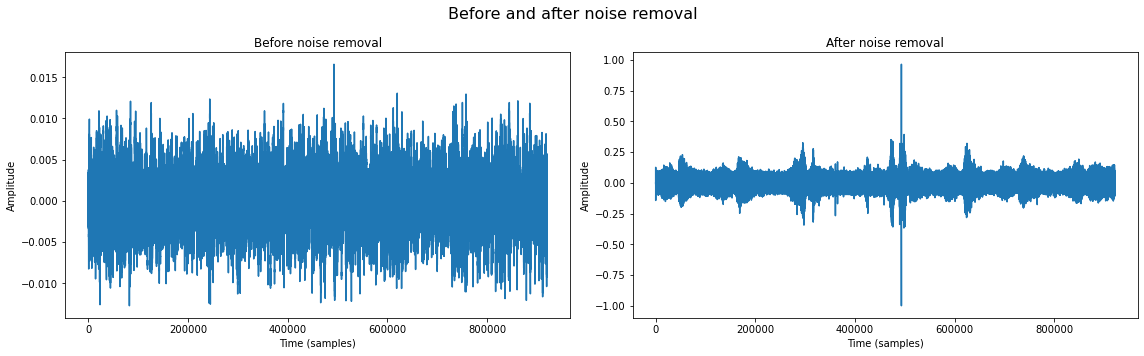

Before noise removal:  (920783,)


After noise removal:  (920783,)


In [42]:


fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sample_idx = 6

fig.suptitle('Before and after noise removal', fontsize=16)

axs[0].plot(audio[sample_idx])
axs[0].set_title('Before noise removal')

axs[1].plot(noise_removed[sample_idx])
axs[1].set_title('After noise removal')

for ax in axs:
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

print('Before noise removal: ', audio[sample_idx].shape)
ipd.display(ipd.Audio(audio[sample_idx], rate=sample_rate))
print('After noise removal: ', noise_removed[sample_idx].shape)
ipd.display(ipd.Audio(noise_removed[sample_idx], rate=sample_rate))

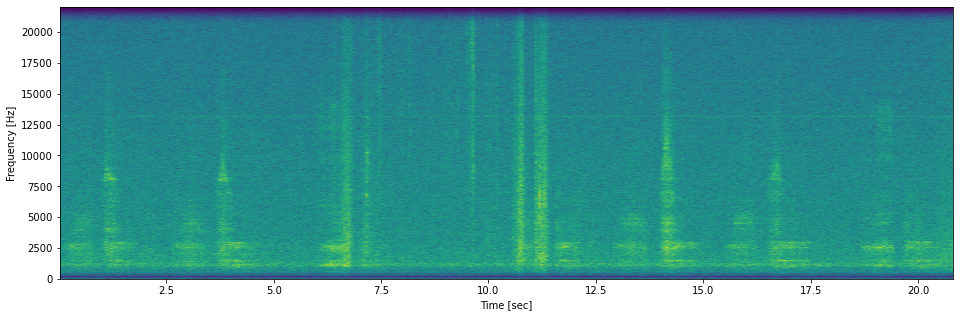

In [43]:
window_size_sec = 0.05
window_size = int(window_size_sec * sample_rate)

def plot_spectrogram(sig_array):
    plt.subplots(figsize=(16, 5))
    plt.pcolormesh(sig_array[1], sig_array[0], np.power(sig_array[2], 0.1), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def get_spectrogram(sig_array):
    spectrogrmas = []
    for sig in sig_array:
        f, t, Sxx = signal.spectrogram(sig, sample_rate, nperseg=window_size)
        spectrogrmas.append((f, t, Sxx))
    return spectrogrmas

spectrograms = get_spectrogram(noise_removed)
plot_spectrogram(spectrograms[sample_idx])

In [44]:
breathing_counts = df['breathing_counts']

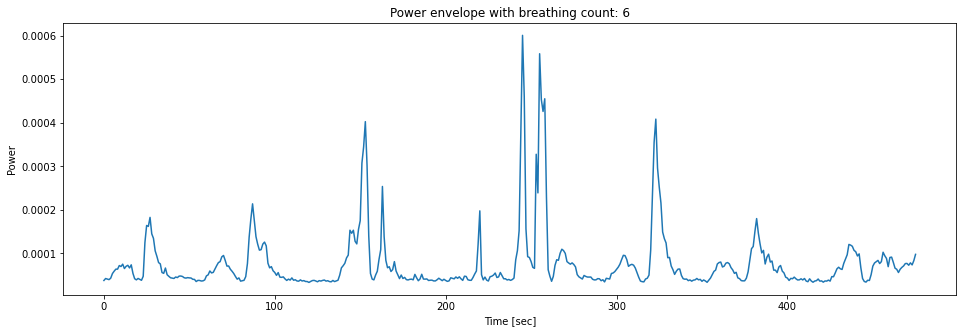

In [45]:
# get power envelope

def get_power_envelope(spectrogram):
    times = []
    power_envelopes = []
    for spec in spectrogram:
        power_envelopes.append(np.sum(spec[2], axis=0))
        times.append(spec[1])
    return times, power_envelopes

times, power_envelopes = get_power_envelope(spectrograms)
power_envelopes[sample_idx].shape

# plot power envelope

def plot_power_envelope(power_envelope, breathing_count):
    plt.subplots(figsize=(16, 5))
    plt.plot(power_envelope)
    plt.ylabel('Power')
    plt.xlabel('Time [sec]')
    plt.title('Power envelope with breathing count: {}'.format(breathing_count))
    plt.show()

plot_power_envelope(power_envelopes[sample_idx], breathing_counts[sample_idx])

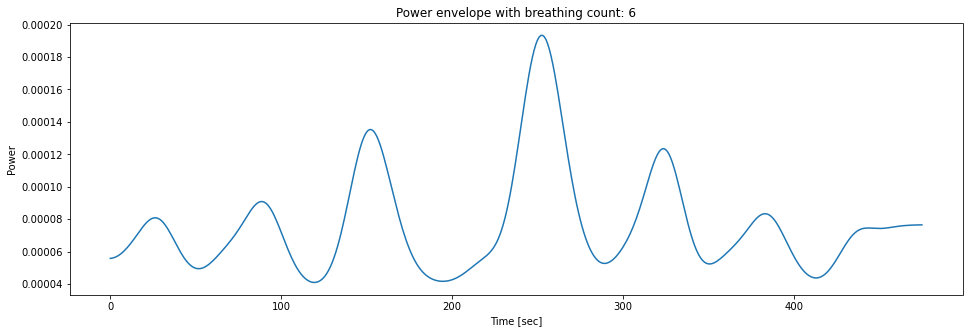

In [46]:
# apply gaussian filter

def apply_gaussian_filter(power_envelope):
    return gaussian_filter1d(power_envelope, sigma=10)

gaussian_filtered = []

for power_envelope in power_envelopes:
    gaussian_filtered.append(apply_gaussian_filter(power_envelope))

plot_power_envelope(gaussian_filtered[sample_idx], breathing_counts[sample_idx])

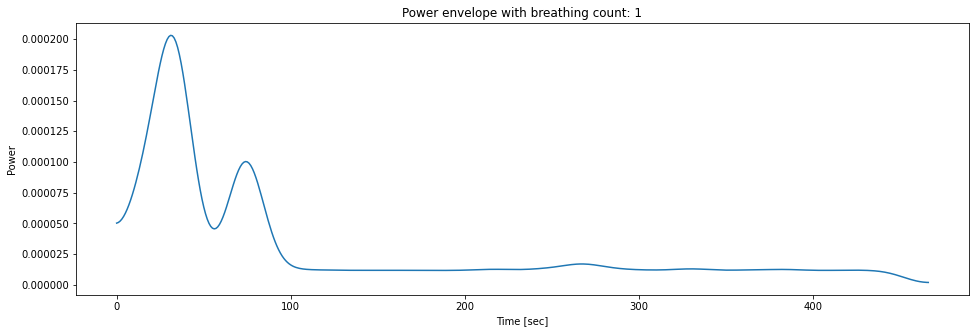

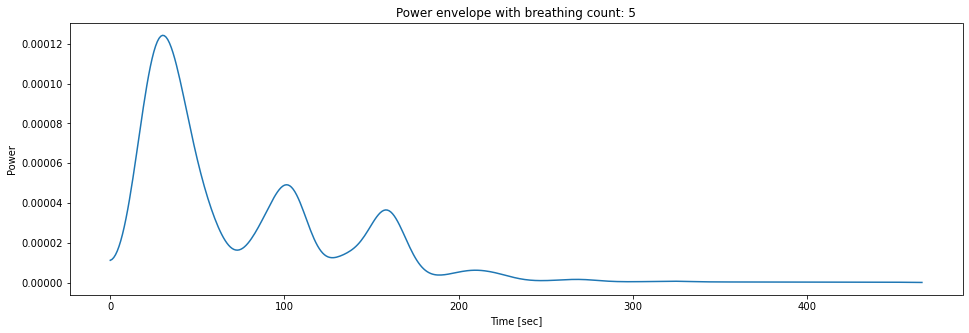

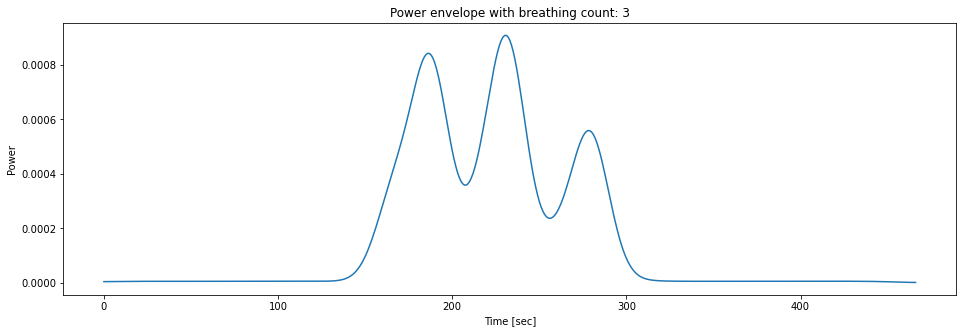

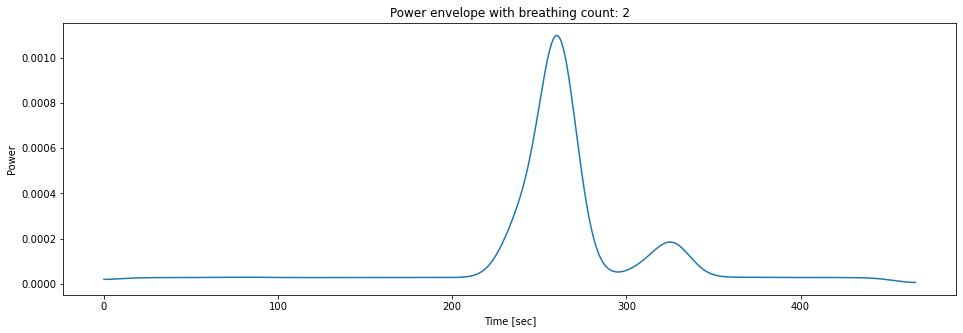

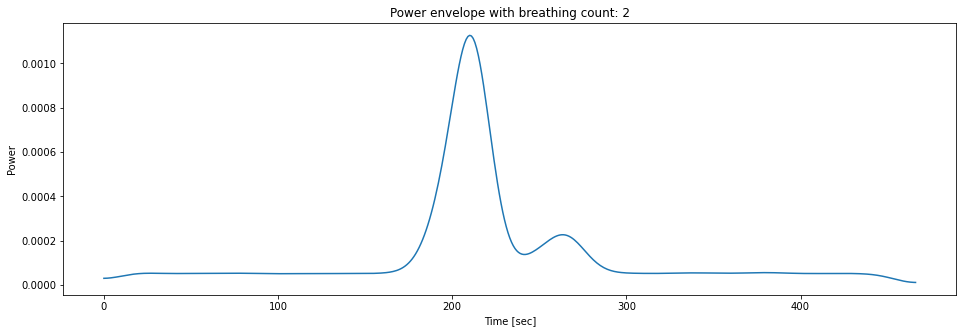

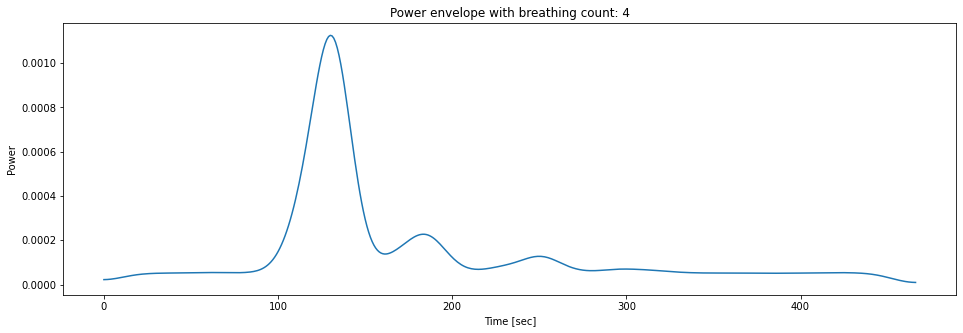

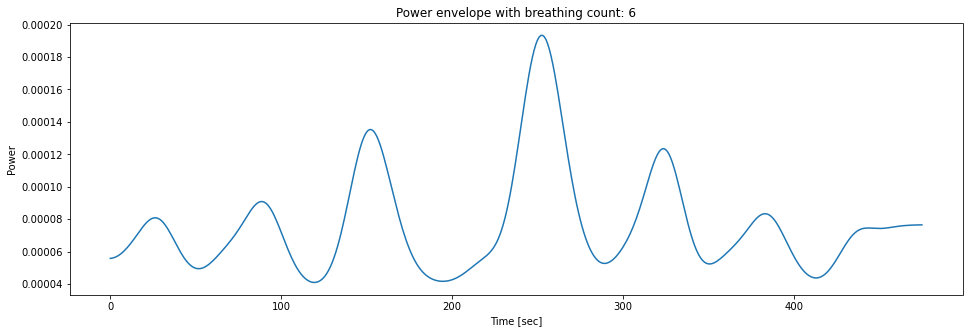

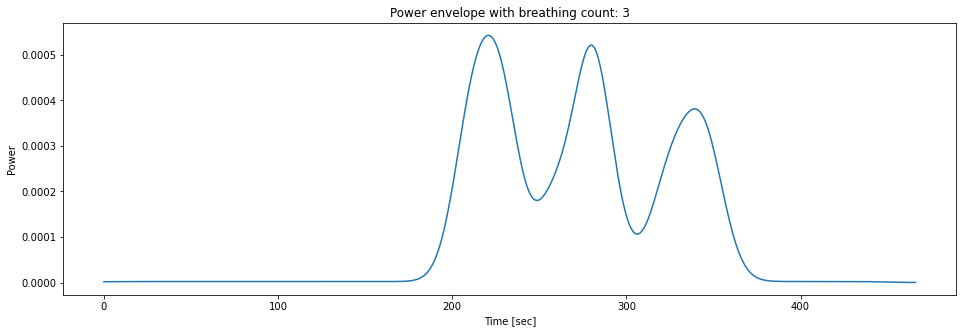

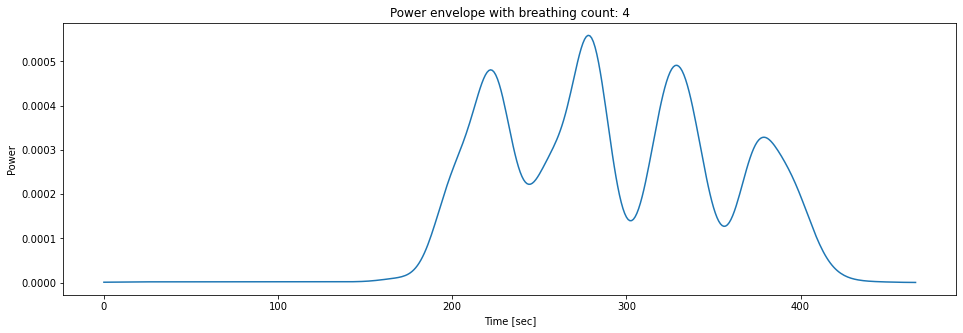

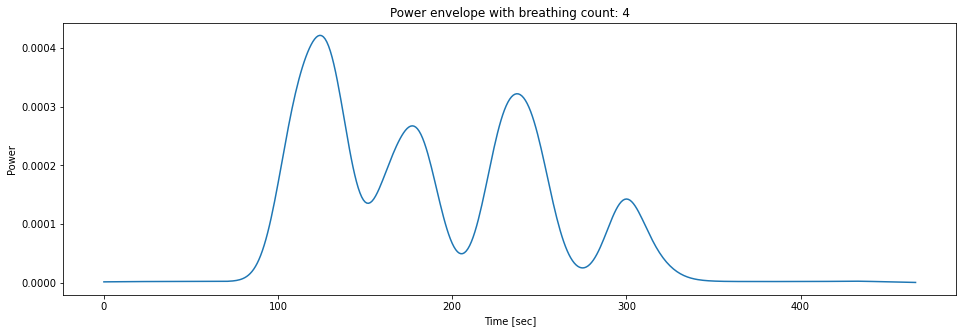

In [12]:
for i in range(len(gaussian_filtered)):
    plot_power_envelope(gaussian_filtered[i], breathing_counts[i])

In [33]:
from scipy.signal import find_peaks

def get_peaks(power_envelope):
    peaks, _ = find_peaks(power_envelope, height=0.0001)
    return peaks

In [37]:
sample_peak = get_peaks(gaussian_filtered[sample_idx])

sample_peak_timing = [times[sample_idx][peak] for peak in sample_peak]

sample_peak_timing

[8.165136054421769, 10.13452380952381, 12.191439909297053]

In [40]:
def peak_plot(power_envelope, time, peaks, breathing_count):
    peak_timing = [time[peak] for peak in peaks]
    plt.subplots(figsize=(16, 5))
    plt.plot(time, power_envelope, color='gray')
    plt.plot(peak_timing, power_envelope[peaks], "v", color='red', markersize=10)
    plt.ylabel('Power')
    plt.xlabel('Time [sec]')
    plt.title('Power envelope with breathing count: {}'.format(breathing_count))
    plt.show()


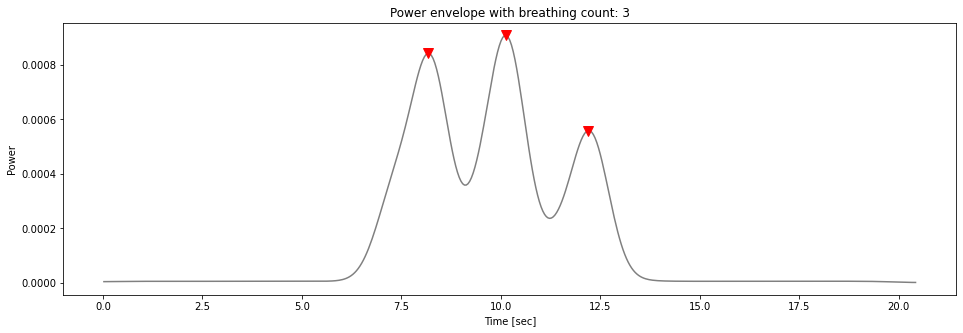

In [41]:
peak_plot(gaussian_filtered[sample_idx], times[sample_idx], sample_peak, breathing_counts[sample_idx])